### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/randomforest_analysis">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Mount with google drive.

In [1]:
from google.colab import drive
drive.mount('/content/dirve')

Mounted at /content/dirve


**`treeinterpreter` . PyPi**

Package for interpreting scikit-learn’s decision tree [Reference](https://pypi.org/project/treeinterpreter/)

In [2]:
!pip install treeinterpreter
from treeinterpreter import treeinterpreter as ti

**`factor-analyzer` · PyPI**

Package to perform exploratory and factor analysis (EFA), with several optional rotations. [Reference](https://pypi.org/project/factor-analyzer/)

In [3]:
!pip install factor_analyzer
from factor_analyzer import *

     |████████████████████████████████| 40kB 3.5MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40398 sha256=415bdf8954df6596b51d184347558d240bcb7eba8ffa6f9359277b70253808ae
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


In [ ]:
!git clone 'http://github.com/Nak007/randomforest_analysis.git'

Other packages.

In [5]:
import pandas as pd, numpy as np, os, pickle, sys
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score,
                             f1_score, 
                             make_scorer)
from sklearn.model_selection import GridSearchCV
pd.options.display.float_format = '{:,.4f}'.format

sys.path.append('/content/randomforest_analysis')
from model_validation import *
from randomforest_analysis import *
from varclus import *
from cluster_visualization import *

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [8]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 50, 
                           n_informative = 15, 
                           n_redundant   = 20, 
                           random_state  = 0, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.7,0.3])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                             for n in range(1,X.shape[1]+1)]) 

### <font color="green" size=5> Variable Clustering </font>

In [9]:
vc = VariableClustering(maxclus=20, maxeigval2=0.9).fit(X)

In [10]:
vc.info.head()

,N_Vars,Eigval1,Eigval2,VarProp,min_RSO,max_RSN,max_RSr
Cluster,,,,,,,
1,4,2.3870,0.6713,0.5967,0.4618,0.3376,0.6605
2,4,2.5550,0.7732,0.6387,0.4753,0.3335,0.6776
3,6,3.2034,0.8930,0.5339,0.4528,0.3895,0.7216
4,4,1.9238,0.9882,0.4809,0.1204,0.2950,0.9295
5,2,1.5379,0.4621,0.7689,0.7689,0.3940,0.3813


In [11]:
vc.r2.head(10)

RS_Own  RS_NC  RS_Ratio
Cluster Variable                           
1       feature_35  0.7266 0.2345    0.3572
        feature_20  0.7132 0.3376    0.4330
        feature_14  0.4618 0.1656    0.6449
        feature_42  0.4854 0.2208    0.6605
2       feature_38  0.7311 0.1513    0.3168
        feature_15  0.7615 0.3335    0.3578
        feature_24  0.5870 0.2143    0.5257
        feature_31  0.4753 0.2257    0.6776
3       feature_04  0.7461 0.3895    0.4159
        feature_30  0.5229 0.1549    0.5646

We can use `cluster_matrix` to visualize results from `VariableClustering` through a matrix of scatter plots.

== Group 3 ==


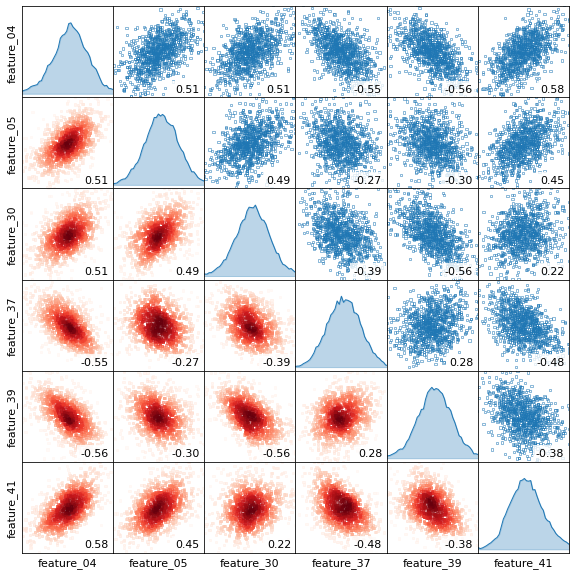

In [12]:
random_cluster = 3 #np.random.randint(1,len(vc.info))
index = vc.clus_corr.index.get_level_values(0)==random_cluster
X0 = X[vc.clus_corr.loc[index].index.get_level_values(1)]
X0, figsize = (X0 - X0.mean()) / X0.std(), ((1.7*X0.shape[1],)*2)

print(f"== Group {random_cluster} ==")
axes = cluster_matrix(X0, off_diagonal="both", 
                      scatter_kwds=dict(cmap="Reds"))
plt.show()

Let's select variable, with the lowest **RS_Ratio** from each **Cluster**.

In [13]:
vc_columns = vc.r2.reset_index().groupby('Cluster').first()["Variable"].values
X = X[vc_columns].copy()

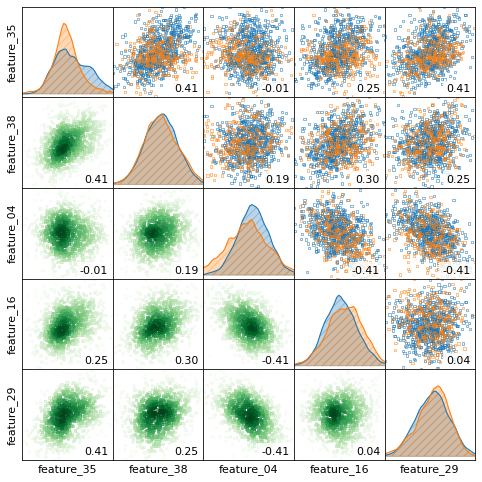

In [14]:
axes = cluster_matrix(X.iloc[:,:5], y, off_diagonal="both",
                      scatter_kwds=dict(cmap="Greens"),
                      hist_kwds=dict(sigma=1, fill_kwds=dict(hatch="///")), 
                      show_corr=True)

### <font color="green" size=5> Split train and test sets </font>

Split data into **_train_**, and **_test_** sets given **_test_size_**

In [15]:
tts_kwargs = {"test_size"   : 0.3 , 
              "shuffle"     : True, 
              "random_state": 0}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwargs)

Determine _**class_weight**_ for imbalanced classes

In [16]:
def ClassWeights(labels):
    '''Determine `class_weight` for imbalanced classes'''
    cls, cnt = np.unique(labels, return_counts=True)
    return dict([(c,np.round(sum(cnt)/n,4)) for c,n in zip(cls,cnt)])

In [17]:
class_weight = ClassWeights(y_train)
class_weight = "balanced"

Summary of **_train_** and **_test_** sets, and _**class_weight**_

In [18]:
def train_test(X_train, X_test, y_train, y_test):
    data = []
    for (nx,ny) in zip([X_train,X_test],[y_train,y_test]):
        weights = dict([(f'weight_{c}',w) for c,w in ClassWeights(ny).items()])
        labels  = dict([(f'class_{c}',(ny==c).sum()) for c in np.unique(ny)])
        data.append({**{'N':nx.shape[0]}, **weights, **labels})
    return pd.DataFrame(data, index=['Train','Test'])

In [19]:
train_test(X_train, X_test, y_train, y_test)

,N,class_0,class_1,weight_0,weight_1
Train,7000,4923,2077,1.4219,3.3702
Test,3000,2063,937,1.4542,3.2017


### <font color="green" size=5> Fitting classifier </font>

In [20]:
def EstimateDepth(*args):
    '''Private function to estimate max_depth 
    for tree-based model'''
    max_len = float(max([len(a) for a in args]))
    return int(np.ceil(np.log2(max_len)))

Estimate **`max_depth`** and specify initial parameters for random forest classifier.

In [21]:
max_depth = EstimateDepth(X_train, X_test)
model = rf(**{"random_state":  0, 
              "n_estimators": 50, 
              "n_jobs"      : -1, 
              "class_weight": class_weight,
              "max_features": "sqrt"})

Specify **`sklearn.metrics`** to evaluate the change of parameter(s).

In [22]:
scoring = {'F1-Score': make_scorer(f1_score), 
           'AUC'     : make_scorer(roc_auc_score),
           'Accuracy': make_scorer(accuracy_score)}

In [23]:
gs = GridSearchCV(model, 
                  param_grid={'max_depth': range(2, np.fmax(max_depth,14))},
                  scoring=scoring, 
                  refit=False, 
                  return_train_score=True, 
                  n_jobs=-1, 
                  cv=3).fit(X_train, y_train)

<font color='blue' size=4>**GridSearchCV result**</font>

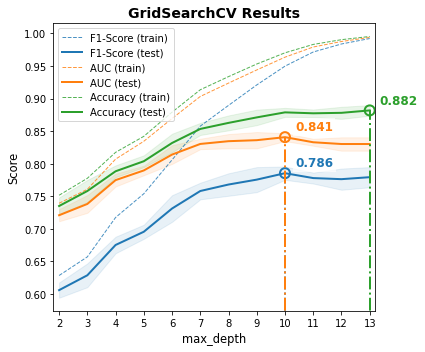

In [24]:
ax = PlotGridSearch(gs, decimal=3)
ax.legend(loc=2)

Select the appropriate number of **`max_depth`**.

In [25]:
init_kwargs = {"random_state": 0, 
               "n_estimators": 50, 
               "n_jobs"      : -1, 
               "class_weight": class_weight, 
               'max_depth'   : 7, 
               "max_features": "sqrt"}

In [26]:
clf = rf(**init_kwargs).fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

Specify parameters for **`eval_classifier`** and build plotting function.

The method indices (parameter: **plots**) are as follows:
- 0 : Confusion matrix, **cfm_plot**
- 1 : F1-Score, **f1score_plot**
- 2 : Gini index, **gini_plot**
- 3 : Distribution of binary classes, **dist_plot**
- 4 : Kolmogorov–Smirnov test, **ks_plot**
- 5 : Gains, **gains_plot**
- 6 : Lift, **lift_plot**

In [27]:
def plotting_classifier(y_true, y_proba):
    # Parameters
    params = {'plots'  : [0, 2, 3, 6],
              'ax_dict': [# Confusion matrix
                          {'threshold' : 0.5, 'mat_dict' : {'cmap':plt.cm.tab20}}, 
                          # Gini index
                          {'plot_dict' : {'color':'blue', 'linestyle':'-'}}, 
                          # Distribution of binary classes
                          {'n_tick':10, 'bins':20, 'labels': ['non-target','target'],
                           'bar_dict': {'width':0.8}}, 
                          # Lift chart
                          {'plot':'rate', 'bound':[0,100], 'step':10, "decimal":2, 
                           'anno_format' : "{:.2f}".format}]}
    fig, axes = Axes2grid(4, 2, figsize=(5, 3.5))
    eval_classifier(y_true, y_proba, **{**params,**{'axes':axes}})
    fig.tight_layout()
    plt.show()

Observe performace of **X_train** after retraining classifier.

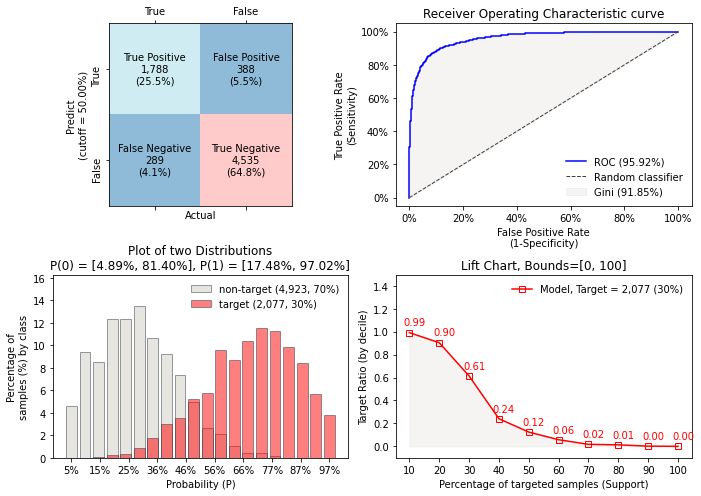

In [28]:
plotting_classifier(y_train, y_train_proba)

Validate performace of model with unseen data, **X_test**.

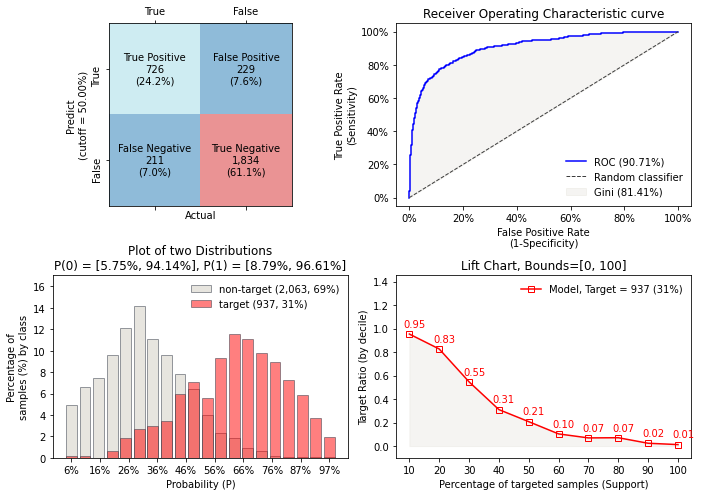

In [29]:
plotting_classifier(y_test, y_test_proba)

**Importance Values**
- sklearn (average decrease in impurity or Information Gain)
- Directional Feature Contributions (DFC)
- Permute variable (Permutation Importance)
- Drop variable (Drop-Column Importance)

In [30]:
model = FeatureImportance().fit(clf, X_train, y_train)

In [31]:
model.info.head(10)

,gain_score,dfc_score,permute_score,drop_score,mean_score
features,,,,,
feature_35,0.1424,0.1566,0.1859,0.1877,0.1713
feature_50,0.1448,0.1530,0.1387,-0.0263,0.1045
feature_44,0.1069,0.1121,0.0992,0.0909,0.1042
feature_47,0.0787,0.1066,0.1055,0.0668,0.0911
feature_22,0.0781,0.0573,0.0554,0.1081,0.0761
feature_06,0.0570,0.0427,0.0708,0.1015,0.0693
feature_38,0.0516,0.0474,0.0586,0.0928,0.0638
feature_29,0.0561,0.0438,0.0648,0.0735,0.0607
feature_04,0.0779,0.0746,0.0479,0.0185,0.0558


<AxesSubplot:title={'center':'Feature Importance\nMean of score(s)'}>

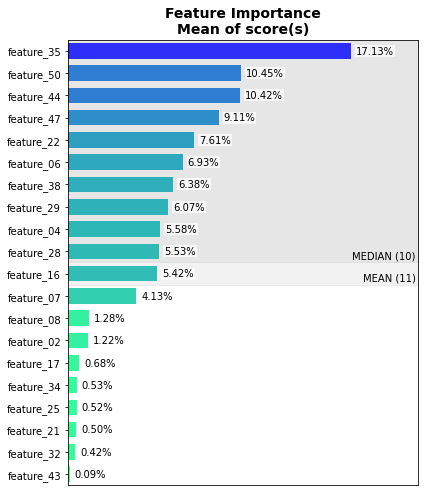

In [32]:
model.plotting("mean_score", sort_by="mean_score")

Select feature(s), whose importance is equal to or greater than defined cutoff.

In [33]:
final_features = [c for c in list(X) if c in model.info.index[:12]]
final_features

['feature_35',
 'feature_38',
 'feature_04',
 'feature_16',
 'feature_29',
 'feature_50',
 'feature_28',
 'feature_06',
 'feature_47',
 'feature_44',
 'feature_22',
 'feature_07']

### <font color="green" size=5> Retrain classifier </font>

Retrain model with new set of variables and validate fitted model accordingly.

In [34]:
clf.fit(X_train[final_features], y_train)
y_train_proba_1 = clf.predict_proba(X_train[final_features])[:,1]
y_test_proba_1  = clf.predict_proba(X_test[final_features] )[:,1]

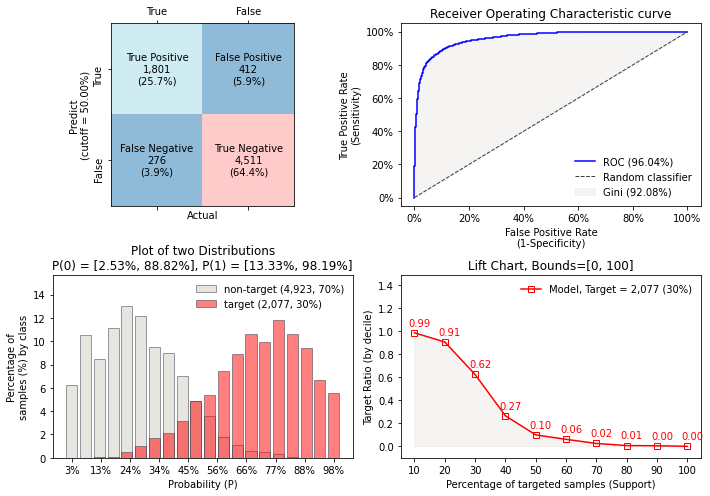

In [35]:
plotting_classifier(y_train, y_train_proba_1)

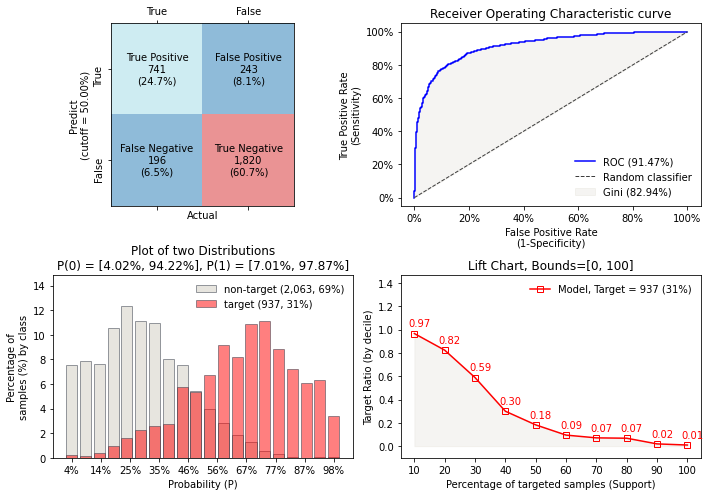

In [36]:
plotting_classifier(y_test, y_test_proba_1)

We will use **`TreeInterpreter`** to observe the relationship between feature contributions and variables. This type of visualization will facilitate an understanding of which features are important for the classification. Use **`Axes2grid`** to help creating multiple axes at specific location inside a regular grid.

In [37]:
model = TreeInterpreter(clf, y_train, X_train[final_features])

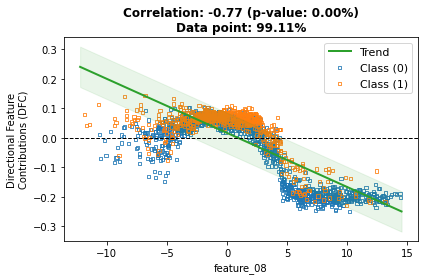

In [38]:
np.random.seed(None)
i = np.random.randint(X_train.shape[1])
ax = model.plotting(X_train.columns[i], tight_layout=True, frac=0.3)

Directional feature contribution can be seen as an average incremental increase/decrease probability from bias.

### <font color="green" size=5> Find random_state </font>

Use **`tts_randomstate`** to determine the best `random_state` in splitting data that optimizes objective function e.g. Flase Negative or Gini Coefficient.

In [39]:
np.random.seed(0)
random_states = np.random.randint(1000, size=30)
random_states

array([684, 559, 629, 192, 835, 763, 707, 359,   9, 723, 277, 754, 804,
       599,  70, 472, 600, 396, 314, 705, 486, 551,  87, 174, 600, 849,
       677, 537, 845,  72])

In [40]:
model = tts_randomstate(clf, X[final_features], y, tts_kwds={"test_size":0.3, "shuffle":True})
model.fit(random_states)

In [41]:
model.info.head()

tp   fp   fn    tn  f1_score  roc_auc_score  \
random_state train                                                  
684          False   728  231  171  1870    0.7836         0.9220   
             True   1829  405  286  4480    0.8411         0.9593   
559          False   697  219  193  1891    0.7719         0.9144   
             True   1825  390  299  4486    0.8412         0.9586   
629          False   674  251  217  1858    0.7423         0.9084   

                    accuracy_score  
random_state train                  
684          False          0.8660  
             True           0.9013  
559          False          0.8627  
             True           0.9016  
629          False          0.8440

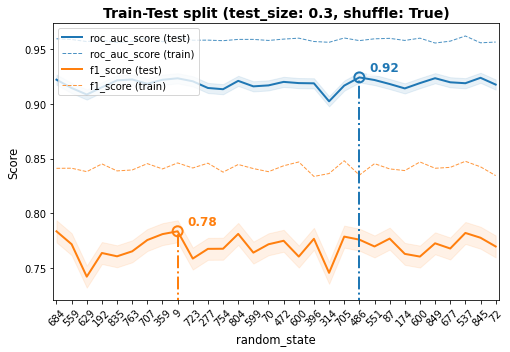

In [42]:
ax = model.plotting(["roc_auc_score", "f1_score"], criterion="max", decimal=2)
ax.legend(loc=2)

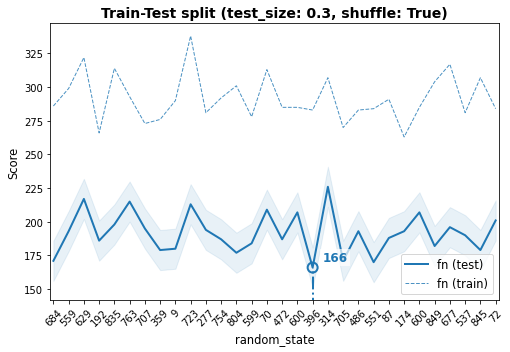

In [43]:
ax = model.plotting(["fn"], decimal=0, criterion="min")

### <font color="green" size=5> Find class_weight </font>

Use **`get_classweights`** to determine the best **`class_weight`** (e.g. from imbalance to balance or vice versa) wrt. measuring metrics.

In [44]:
start = [1, 1]
stop  = list(ClassWeights(y_train).values())
num   = 15
backward, forward = 5, 5
class_weights  = get_classweights([1,1], stop, num, backward, forward)

In [45]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 50, 
            "n_jobs"      : -1, 
            "max_depth"   : 6, 
            "max_features": "sqrt"})

In [46]:
scoring = {'F1-Score' : make_scorer(f1_score), 
           'AUC'      : make_scorer(roc_auc_score),
           'Recall'   : make_scorer(recall_score)}

In [47]:
gs = GridSearchCV(clf, 
                  param_grid={"class_weight": class_weights},
                  scoring=scoring, 
                  refit=False, 
                  return_train_score=True, 
                  n_jobs=-1, 
                  cv=3).fit(X_train, y_train)

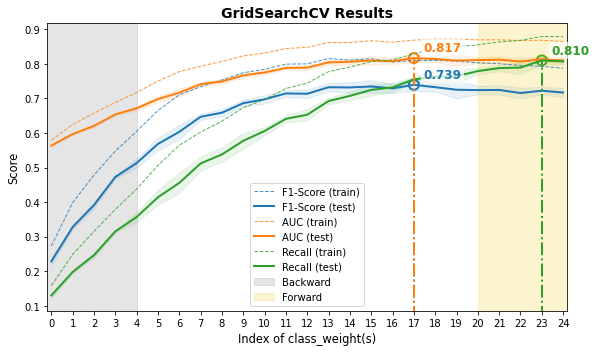

In [48]:
ax = plt.subplots(figsize=(9,5))[1]
ax = PlotGridSearch(gs, decimal=3, ax=ax)
ax.axvspan(-1, backward-1, alpha=0.2, 
           label="Backward", color="grey")
ax.axvspan(num+backward, len(class_weights), 
           alpha=0.2, label="Forward", 
           color="#f1c40f")
ax.legend(loc=0)
ax.set_xticklabels(range(len(class_weights)))
ax.set_xlabel("Index of class_weight(s)")
plt.show()

### <font color="green" size=5> Final classifier : retrain classifier (random_state, class_weight) </font>

Retrain model with new **_train_** & **_test_** sets, and **class_weight** and validate fitted model accordingly.

In [49]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 486, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X[final_features], y, **tts_kwds)

In [50]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 50, 
            "n_jobs"      : -1, 
            "class_weight": class_weights[17], 
            "max_depth"   : 6, 
            "max_features": "sqrt"})

In [51]:
clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

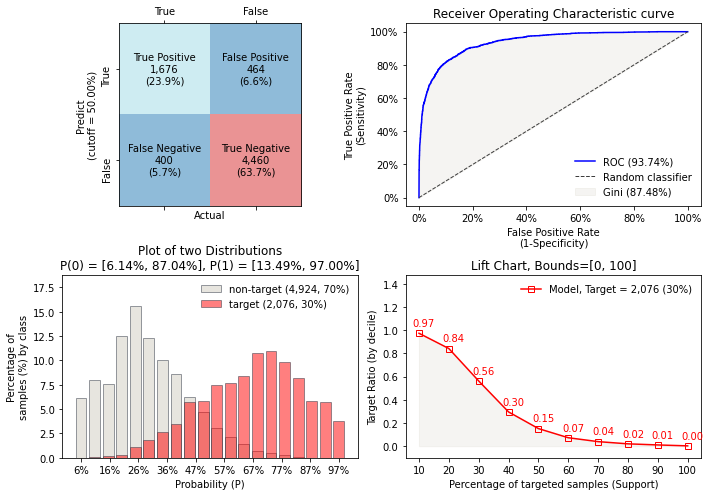

In [52]:
plotting_classifier(y_train, y_train_proba)

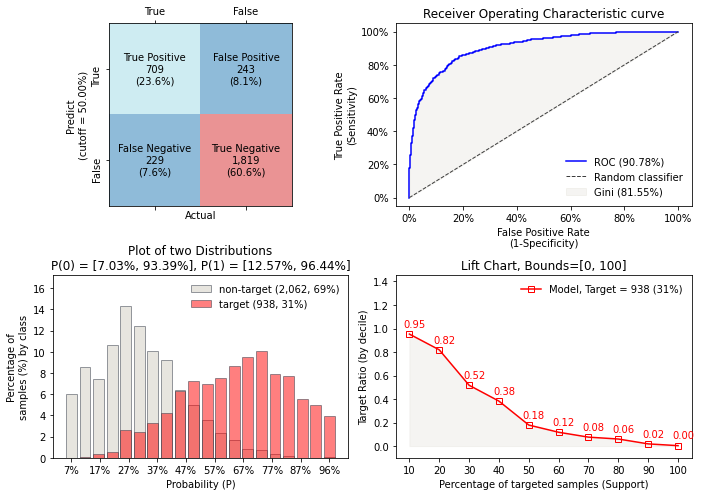

In [53]:
plotting_classifier(y_test, y_test_proba)

In [54]:
fi_model = FeatureImportance().fit(clf, X_train, y_train)

In [55]:
fi_model.info.head()

,gain_score,dfc_score,permute_score,drop_score,mean_score
features,,,,,
feature_35,0.1529,0.1621,0.2102,0.1592,0.1752
feature_50,0.1852,0.2223,0.1997,-0.0467,0.1435
feature_44,0.1068,0.1007,0.1073,0.1061,0.1077
feature_47,0.0842,0.1035,0.0974,0.1150,0.1024
feature_22,0.0933,0.0679,0.0605,0.1077,0.0843


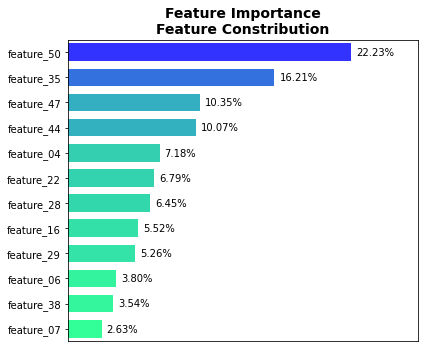

In [56]:
ax = fi_model.plotting("dfc_score")

In [57]:
ti_model = TreeInterpreter(clf, y_train, X_train)

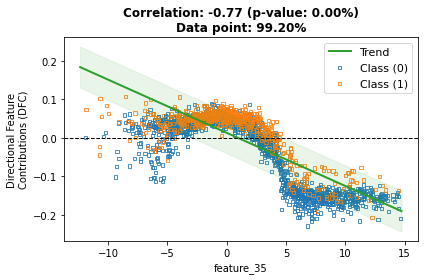

In [60]:
np.random.seed(None)
var = np.random.choice(X_train.columns)
ax  = ti_model.plotting(var, tight_layout=True, frac=0.3)

Save classifer.

In [ ]:
pickle.dump(clf, open('final_model.sav','wb'))

### <font color="green" size=5> Calibration of probability </font>

The purpose of calibration is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approx. 80% actually belong to the positive class. The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. [Reference](https://scikit-learn.org/stable/modules/calibration.html) 

In [61]:
from sklearn.linear_model import LogisticRegression

# Fit model with test data (reduce bias)
calibrator = LogisticRegression(max_iter=500, tol=1e-4)
calibrator.fit(y_test_proba.reshape(-1,1), y_test)

calibr_y_train = calibrator.predict_proba(y_train_proba.reshape(-1,1))[:,1]
calibr_y_test  = calibrator.predict_proba(y_test_proba.reshape(-1,1))[:,1]

Use **`CalibatorEvaluation`** to evaluate the calibrated probabilities.

In [62]:
train = (y_test , calibr_y_test)
test  = (y_train, calibr_y_train)
calibr= CalibatorEvaluation(equal_width=False, bins=range(1,21)).fit(train, test)

Use **`plotting_metric()`** to observe how change in number of bins can affect evaluation metrics i.e. gini impurity (`gini`), and root mean square error (`rmse`).

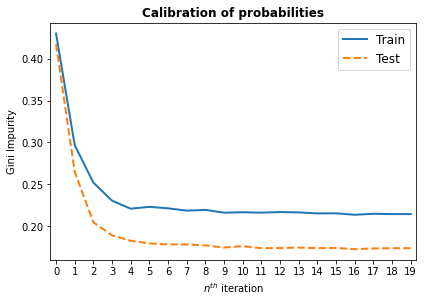

In [63]:
ax = calibr.plotting_metric("gini")

Use **`plotting_reliability()`** to plot calibration curve or so-called **reliability curve**.

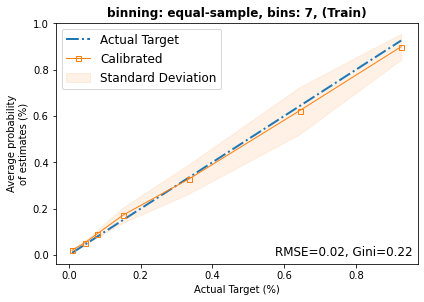

In [64]:
n_iter = 6
ax = calibr.plotting_reliability(n_iter, use_train=True)

Use **`plotting_hist()`** to enable us to compare calibrated estimates and actual percentage.

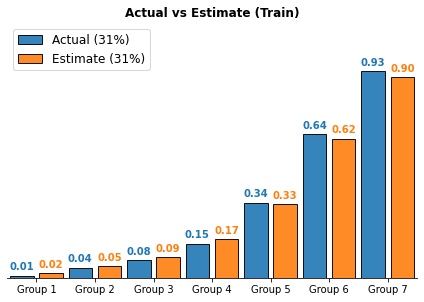

In [75]:
ax = calibr.plotting_hist(n_iter, use_train=True)

Summary table

In [66]:
calibr.result[n_iter].train.info

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets
0,0.0000,0.0346,0.1430,0.0108,0.0345,0.0208,0.0065,0.0093
1,0.0346,0.0687,0.1427,0.0347,0.0687,0.0523,0.0097,0.0444
2,0.0687,0.1221,0.1430,0.0687,0.1220,0.0917,0.0151,0.0793
3,0.1221,0.2314,0.1427,0.1224,0.2308,0.1729,0.0331,0.1519
4,0.2314,0.4491,0.1430,0.2316,0.4491,0.3291,0.0635,0.3357
5,0.4491,0.7923,0.1427,0.4491,0.7923,0.6226,0.1014,0.6425
6,0.7923,1.0000,0.1430,0.7923,0.9814,0.8990,0.0557,0.9254


Assign probabilities into groups with respect to `bin_edges`.

In [67]:
estimates = np.round(clf.predict_proba(X[final_features])[:,1], 4)

Calibrate the estimates from initial estimator.

In [68]:
b1 = float(calibrator.coef_)
b0 = float(calibrator.intercept_)
estimates = 1/(1 + np.exp(-((estimates * b1) + b0)))

In [69]:
bin_edges   = calibr.result[n_iter].train.bin_edges
group_proba = np.digitize(estimates, bin_edges)

### <font color="green" size=5> Score </font>

Use **`cal_score()`** to convert probability into score.

In [70]:
p = min(estimates)
score_kwds = dict(pdo=20, point=0, odd=p/(1-p), 
                  min_prob=min(estimates),
                  max_prob=max(estimates))

In [71]:
final_group = pd.DataFrame(calibr.result[n_iter].train.info)
final_group["min_score"] = cal_score(final_group["r_min"], **score_kwds).astype(int)
final_group["max_score"] = cal_score(final_group["r_max"], **score_kwds).astype(int)
final_group["group"] = np.arange(1, len(final_group)+1)
scores = cal_score(estimates, **score_kwds).astype(int)

In [72]:
final_group.set_index("group")

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,min_score,max_score
group,,,,,,,,,,
1,0.0000,0.0346,0.1430,0.0108,0.0345,0.0208,0.0065,0.0093,0,37
2,0.0346,0.0687,0.1427,0.0347,0.0687,0.0523,0.0097,0.0444,37,58
3,0.0687,0.1221,0.1430,0.0687,0.1220,0.0917,0.0151,0.0793,58,76
4,0.1221,0.2314,0.1427,0.1224,0.2308,0.1729,0.0331,0.1519,76,98
5,0.2314,0.4491,0.1430,0.2316,0.4491,0.3291,0.0635,0.3357,98,127
6,0.4491,0.7923,0.1427,0.4491,0.7923,0.6226,0.1014,0.6425,127,171
7,0.7923,1.0000,0.1430,0.7923,0.9814,0.8990,0.0557,0.9254,171,249


### <font color="green" size=5> Save datasets </font>


In [73]:
final_X = X[final_features].copy()
final_X["target"] = y
final_X["proba"]  = estimates
final_X["train"]  = np.where(final_X.index.isin(X_train.index),1,0)
final_X["group"]  = group_proba
final_X["score"]  = scores
final_X = final_X.merge(final_group[["group"]], how="left", on="group")

In [74]:
final_X.head()

,feature_35,feature_38,feature_04,feature_16,feature_29,feature_50,feature_28,feature_06,feature_47,feature_44,feature_22,feature_07,target,proba,train,group,score
0,-5.3025,-3.8473,-5.8209,5.3102,-1.5390,-3.5112,-2.8553,3.6661,1.3341,-3.5267,-5.1027,-0.9490,1,0.9767,1,7,241
1,12.6742,1.9356,-3.3807,5.3643,2.1548,-0.4721,-4.2643,-0.6984,-1.6154,0.5863,-1.5709,0.0086,0,0.0234,1,1,25
2,3.0645,-4.2059,1.5571,-10.6994,1.6208,-2.8808,-1.1452,-2.2951,-0.3335,0.5159,-0.2824,4.0456,1,0.5521,1,6,139
3,5.1430,1.1679,0.5895,6.3558,0.7231,-0.3071,-2.8606,-2.2330,-0.7059,-0.4430,2.2767,1.6653,0,0.0451,0,2,45
4,0.5939,-0.7130,2.7138,2.5037,-3.7090,2.7843,-5.5655,-0.7743,1.6192,0.2849,1.2862,0.7942,0,0.0478,0,2,47


In [ ]:
final_X.to_csv(f'X_{yyyymm}.txt', index=False, sep='|')
final_group.to_csv(f'Group_{yyyymm}.txt', index=False, sep='|')